In [2]:
import re
import os
import sys
import torch
import librosa
import librosa.display

import numpy as np
import IPython.display as ipd
import shutil


from pprint import pprint

tacotron_dir = '/root/Tacotron2'
sys.path.append(tacotron_dir)

def move_file(src_path, dst_path):
    shutil.move(src_path, dst_path)

def copy_file(src_path, dst_path):
    shutil.copy(src_path, dst_path)

def subdir(name):
    return os.path.join(tacotron_dir, name)

def ojoin(*args):
    return os.path.join(*args)

def read_lines(path):
    with open(path) as f:
        return [l.strip() for l in f]
    
def assert_equal(a, b):
    assert a == b, f'{a} != {b}'
    

scripts_dir = subdir('scripts')
notebooks_dir = subdir('notebooks')

data_dir = subdir('data')
my_voice_dir = subdir('data/my_voice')
wavs_dir = ojoin(my_voice_dir, 'wavs')

ljspeech_wavs_dir = ojoin(tacotron_dir, 'LJSpeech-1.1', 'wavs')
filelists_dir = ojoin(tacotron_dir, 'filelists')

In [3]:
ljspeech_filelist = read_lines(ojoin(filelists_dir, 'ljs_audio_text_train_filelist.txt'))
ljspeech_filelist[:5]

['LJSpeech-1.1/wavs/LJ050-0234.wav|It has used other Treasury law enforcement agents on special experiments in building and route surveys in places to which the President frequently travels.',
 'LJSpeech-1.1/wavs/LJ019-0373.wav|to avail himself of his powers, as it was difficult to bring home the derelictions of duties and evasion of the acts. Too much was left to the inspectors.',
 'LJSpeech-1.1/wavs/LJ050-0207.wav|Although Chief Rowley does not complain about the pay scale for Secret Service agents,',
 'LJSpeech-1.1/wavs/LJ048-0203.wav|The three officers confirm that their primary concern was crowd and traffic control,',
 'LJSpeech-1.1/wavs/LJ003-0182.wav|The tried and the untried, young and old, were herded together']

In [4]:
my_voice_filelist = read_lines(ojoin(my_voice_dir, 'my_voice_train_filelist.txt'))
my_voice_filelist = list(filter(
    lambda s: re.search(r'LJSpeech_\d', s),
    my_voice_filelist))
my_voice_filelist

['my_voice/wavs/LJSpeech_0.wav|It has used other Treasury law enforcement agents on special experiments in building and route surveys in places to which the President frequently travels.',
 'my_voice/wavs/LJSpeech_1.wav|to avail himself of his powers, as it was difficult to bring home the derelictions of duties and evasion of the acts. Too much was left to the inspectors.',
 'my_voice/wavs/LJSpeech_2.wav|Although Chief Rowley does not complain about the pay scale for Secret Service agents,',
 'my_voice/wavs/LJSpeech_3.wav|The three officers confirm that their primary concern was crowd and traffic control,',
 'my_voice/wavs/LJSpeech_4.wav|The tried and the untried, young and old, were herded together',
 'my_voice/wavs/LJSpeech_5.wav|According to Marina Oswald, he thought that would help him when he got to Cuba.',
 'my_voice/wavs/LJSpeech_6.wav|The proposal made was to purchase some fifty thousand square feet between Newgate, Warwick Lane, and the Sessions House,',
 'my_voice/wavs/LJSpee

In [21]:
from typing import Tuple

def _get_stuff(index: int) -> Tuple[str, str]:
    """Sorry?"""
    my_voice_entry = [x for x in my_voice_filelist if f'LJSpeech_{index}.wav' in x][0]
    my_voice_fpath, my_voice_text = my_voice_entry.split('|')
    my_voice_fpath = ojoin(data_dir, my_voice_fpath)
    assert os.path.exists(my_voice_fpath), my_voice_fpath
    
    original_entry = ljspeech_filelist[index]
    original_fpath, original_text = original_entry.split('|')
    original_fpath = ojoin(tacotron_dir, original_fpath)
    assert os.path.exists(original_fpath), original_fpath
    
    assert_equal(my_voice_text, original_text)
    return my_voice_text, my_voice_fpath, original_fpath

def get_paths(index: int) -> Tuple[str, str]:
    _, my_voice_fpath, original_fpath = _get_stuff(index)
    return my_voice_fpath, original_fpath

def get_text(index: int) -> Tuple[str, str]:
    text, _, _ = _get_stuff(index)
    return text

def fix_sr_and_trim(wav_file, top_db=60):
    y_orig, sr = librosa.load(wav_file, sr=22050)
    y, index = librosa.effects.trim(y_orig, top_db=top_db)
    print(f'trimmed {len(y_orig[index[0]:index[1]])} samples')
    librosa.output.write_wav(wav_file, y, 22050)

def play_mine(index: int, top_db=60):
    path, _ = get_paths(index)
    copy_file(path, '/tmp/hi.wav')
    fix_sr_and_trim('/tmp/hi.wav', top_db=top_db)
    return ipd.Audio('/tmp/hi.wav', rate=22050, autoplay=True)
    
def play_original(index: int):
    _, path = get_paths(index)
    print('playing', path)
    return ipd.Audio(path, rate=22050, autoplay=True)

In [6]:
INDEX = 30
pprint(get_paths(INDEX))
pprint(get_text(INDEX))

('/root/Tacotron2/data/my_voice/wavs/LJSpeech_30.wav',
 '/root/Tacotron2/LJSpeech-1.1/wavs/LJ039-0237.wav')
'The Commission agrees with the testimony of Marine marksmanship expert Zahm'


In [7]:
play_mine(INDEX)

trimmed 80128 samples


In [8]:
play_mine(INDEX, top_db=30)

trimmed 80128 samples


In [9]:
play_original(INDEX)

# Librosa Stuff

Librosa [glossary](https://librosa.github.io/librosa/glossary.html):

```
time series
    Typically an audio signal, denoted by ``y``, and represented as a
    one-dimensional *numpy.ndarray* of floating-point values.  ``y[t]`` 
    corresponds to amplitude of the waveform at sample ``t``.

sampling rate
    The (positive integer) number of samples per second of a time series.  
    This is denoted by an integer variable ``sr``.

frame
    A short slice of a :term:`time series` used for analysis purposes.  This
    usually corresponds to a single column of a spectrogram matrix.

window
    A vector or function used to weight samples within a frame when computing
    a spectrogram.

frame length
    The (positive integer) number of samples in an analysis window (or
    :term:`frame`).
    This is denoted by an integer variable ``n_fft``.

hop length
    The number of samples between successive frames, e.g., the columns
    of a spectrogram.  This is denoted as a positive integer ``hop_length``.

window length
    The length (width) of the window function (e.g., Hann window).  Note that this
    can be smaller than the :term:`frame length` used in a short-time Fourier
    transform.  Typically denoted as a positive integer variable ``win_length``.

spectrogram
    A matrix ``S`` where the rows index frequency bins, and the columns index
    frames (time).  Spectrograms can be either real-valued or complex-valued.  By
    convention, real-valued spectrograms are denoted as *numpy.ndarray*\ s ``S``,
    while complex-valued STFT matrices are denoted as ``D``.

onset (strength) envelope
    An onset envelope ``onset_env[t]`` measures the strength of note onsets at
    frame ``t``.  Typically stored as a one-dimensional *numpy.ndarray* of
    floating-point values ``onset_envelope``.

chroma
    Also known as pitch class profile (PCP).  Chroma representations measure the
    amount of relative energy in each pitch class (e.g., the 12 notes in the 
    chromatic scale) at a given frame/time.
```

In [10]:
import librosa
import librosa.display

import matplotlib as mpl

import matplotlib.pyplot as plt
import IPython.display as ipd


def print_str(**kwargs):
    res = [f'{k}={v}' for k, v in kwargs.items()]
    print(','.join(res))
    

def plot_spectrogram(wav_fpath, 
                     n_fft=2048, 
                     hop_length=512, 
                     n_mels=128,
                     start_index=1):
    
    y, sr = librosa.load(wav_fpath)
    print(f'sampling_rate={sr}')
    
    # trim silent edges
    audio, _ = librosa.effects.trim(y, top_db=50)
    
    plt.subplot(2, 2, start_index+1)
    # Time-domain waveform plot.
    librosa.display.waveplot(
        audio,
        sr=sr)
    
    print(f'audio contains {len(audio)} samples. ')
    print(f'We will sample the audio with frames of size {n_fft}, and with stride={hop_length}')
    print(f'Approx expected number of frames:', (len(audio) - n_fft) // hop_length + 1)
    
    pprint(f'audio.shape={audio.shape}')
    S = librosa.feature.melspectrogram(
        audio, 
        sr=sr, 
        n_fft=n_fft, 
        hop_length=hop_length, 
        n_mels=n_mels)
    print('S=', type(S), 'WITH SHAPE', S.shape)
    S_DB = librosa.power_to_db(
        S, 
        ref=np.max)
    
    plt.subplot(2, 2, start_index)
    librosa.display.specshow(
        S_DB, 
        sr=sr, 
        hop_length=hop_length, 
        x_axis='time', 
        y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    
    print(f'Actual spectrogram has {S_DB.shape[1]} frames.')

    
def analyze(index: int):
    my_path, original_path = get_paths(index)
    print_str(my_path=my_path, original_path=original_path)
    print_str(text=get_text(index))
    
    fig, axes = plt.subplots(
        nrows=2, ncols=2, 
        figsize=(12, 8))
    
    print('Plotting my spectrogram...')
    plot_spectrogram(
        my_path, 
        start_index=1)
    axes[0][0].set_title(my_path)
    
    
    print('Plotting original spectrogram...')
    plot_spectrogram(
        original_path, 
        start_index=3)
    axes[1][0].set_title(original_path)
    
    plt.tight_layout()
    plt.show()

In [22]:
play_original(381)

playing /root/Tacotron2/LJSpeech-1.1/wavs/LJ007-0141.wav


In [18]:
play_mine(381)

trimmed 96256 samples


my_path=/root/Tacotron2/data/my_voice/wavs/LJSpeech_381.wav,original_path=/root/Tacotron2/LJSpeech-1.1/wavs/LJ007-0141.wav
text=and "to dispose him, by meditation and seclusion, to return to an honest life."
Plotting my spectrogram...
sampling_rate=22050
audio contains 96256 samples. 
We will sample the audio with frames of size 2048, and with stride=512
Approx expected number of frames: 185
'audio.shape=(96256,)'
S= <class 'numpy.ndarray'> WITH SHAPE (128, 189)
Actual spectrogram has 189 frames.
Plotting original spectrogram...
sampling_rate=22050
audio contains 126877 samples. 
We will sample the audio with frames of size 2048, and with stride=512
Approx expected number of frames: 244
'audio.shape=(126877,)'
S= <class 'numpy.ndarray'> WITH SHAPE (128, 248)
Actual spectrogram has 248 frames.


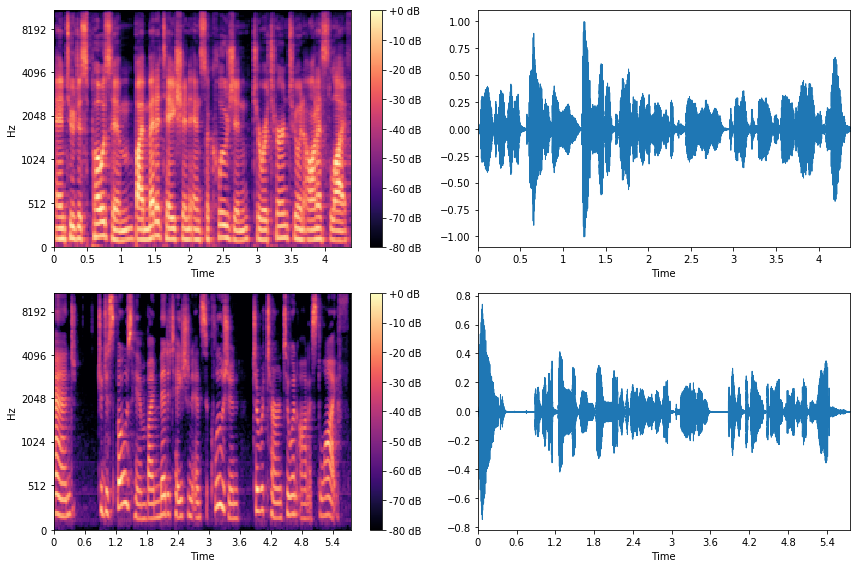

In [20]:
analyze(381)

my_path=/root/Tacotron2/data/my_voice/wavs/LJSpeech_3.wav,original_path=/root/Tacotron2/LJSpeech-1.1/wavs/LJ048-0203.wav
text=The three officers confirm that their primary concern was crowd and traffic control,
Plotting my spectrogram...
sampling_rate=22050
audio contains 82944 samples. 
We will sample the audio with frames of size 2048, and with stride=512
Approx expected number of frames: 159
'audio.shape=(82944,)'
S= <class 'numpy.ndarray'> WITH SHAPE (128, 163)
Actual spectrogram has 163 frames.
Plotting original spectrogram...
sampling_rate=22050
audio contains 117405 samples. 
We will sample the audio with frames of size 2048, and with stride=512
Approx expected number of frames: 226
'audio.shape=(117405,)'
S= <class 'numpy.ndarray'> WITH SHAPE (128, 230)
Actual spectrogram has 230 frames.


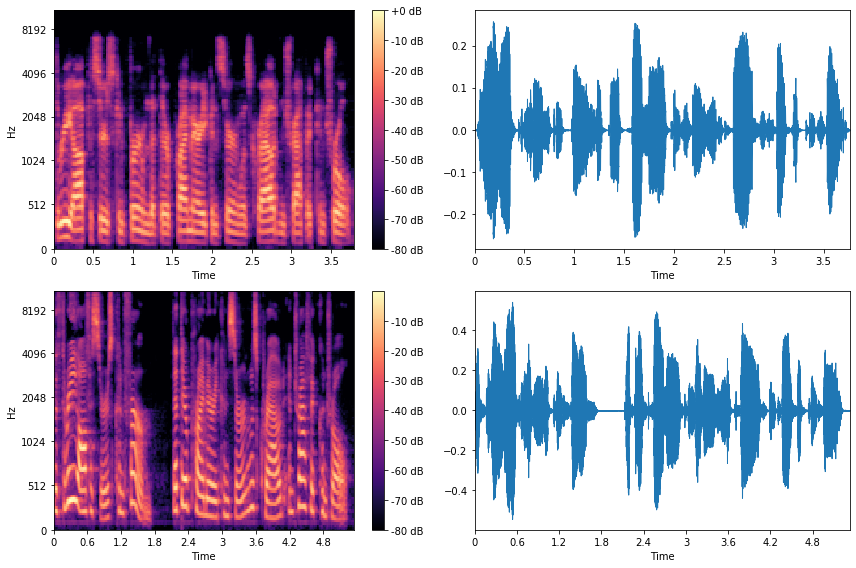

In [13]:
analyze(INDEX)

In [ ]:
plot_spectrogram(filename)

In [ ]:
filename = ojoin(wavs_dir, 'LJSpeech_67.wav')
ipd.Audio(ojoin(wavs_dir, filename), rate=22050)

In [ ]:
plot_spectrogram(filename)

In [ ]:
y, sr = librosa.load(filename)
# trim silent edges
whale_song, _ = librosa.effects.trim(y)
librosa.display.waveplot(whale_song, sr=sr)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
n_fft = 2048
D = np.abs(librosa.stft(
    whale_song[:n_fft], n_fft=n_fft,
    hop_length=n_fft+1))
plt.plot(D)

In [ ]:
import matplotlib.pyplot as plt
hop_length = 512
D = np.abs(librosa.stft(
    whale_song, n_fft=n_fft,  
    hop_length=hop_length))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear')
plt.colorbar()

In [ ]:
DB = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(
    DB, sr=sr, hop_length=hop_length, 
    x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')

In [ ]:
n_mels = 128
mel = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)

In [ ]:
plt.figure(figsize=(15, 4));
plt.subplot(1, 3, 1);
librosa.display.specshow(mel, sr=sr, hop_length=hop_length, 
                         x_axis='linear');
plt.ylabel('Mel filter');
plt.colorbar();
plt.title('1. Our filter bank for converting from Hz to mels.');
plt.subplot(1, 3, 2);
mel_10 = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=10)
librosa.display.specshow(mel_10, sr=sr, hop_length=hop_length, 
                         x_axis='linear');
plt.ylabel('Mel filter');
plt.colorbar();
plt.title('2. Easier to see what is happening with only 10 mels.');
plt.subplot(1, 3, 3);
idxs_to_plot = [0, 9, 49, 99, 127]
for i in idxs_to_plot:
    plt.plot(mel[i]);
plt.legend(labels=['{}'.format(i+1) for i in idxs_to_plot]);
plt.title('3. Plotting some triangular filters separately.');
plt.tight_layout();

In [ ]:
plt.plot(D[:, 1]);
plt.plot(mel.dot(D[:, 1]));
plt.legend(labels=['Hz', 'mel']);
plt.title('One sampled window for example, before and after converting to mel.')

In [ ]:
S = librosa.feature.melspectrogram(
    whale_song, sr=sr, n_fft=n_fft, 
    hop_length=hop_length, 
    n_mels=n_mels)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(
    S_DB, sr=sr, hop_length=hop_length, 
    x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');

# Graveyard

In [ ]:
import shutil

def move_file(src_path, dst_path):
    shutil.move(src_path, dst_path)


def copy_file(src_path, dst_path):
    shutil.copy(src_path, dst_path)


wav_files = ['my_voice/wavs/i_like_dogs_0.wav|I like dogs.']
mel_files = ['my_voice/mels/i_like_dogs_0.pt|I like dogs.']
for i in range(1, 100):
    copy_file(ojoin(wavs_dir, 'i_like_dogs_0.wav'), ojoin(wavs_dir, f'i_like_dogs_{i}.wav'))
    wav_files.append(f'my_voice/wavs/i_like_dogs_{i}.wav|I like dogs.')
    
for i in range(1, 100):
    ildirld = 'i_like_dogs_i_really_like_dogs'
    copy_file(ojoin(wavs_dir, f'{ildirld}_0.wav'), ojoin(wavs_dir, f'{ildirld}_{i}.wav'))
    wav_files.append(f'my_voice/wavs/{ildirld}_{i}.wav|I like dogs. I really like dogs.')
    
for i in range(1, 100):
    ildirld = 'ildirld'
    copy_file(ojoin(wavs_dir, f'{ildirld}_0.wav'), ojoin(wavs_dir, f'{ildirld}_{i}.wav'))
    wav_files.append(f'my_voice/wavs/{ildirld}_{i}.wav|I like dogs. I really like dogs.')

with open(wavs_train_list_path, 'w+') as f:
    f.write('\n'.join(wav_files))
    
# with open(mels_train_list_path, 'w+') as f:
#     f.write('\n'.join(mel_files))